# Let's replace the nn model with a parameterised quantum circuit

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from data import harmonic_oscillator_solution
from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
from model import FCN, Hybrid_QN, Pure_QN
from utils import draw_circuit

import pennylane as qml

from IPython.display import clear_output

In [2]:
torch.manual_seed(123)
n_qubits = 4

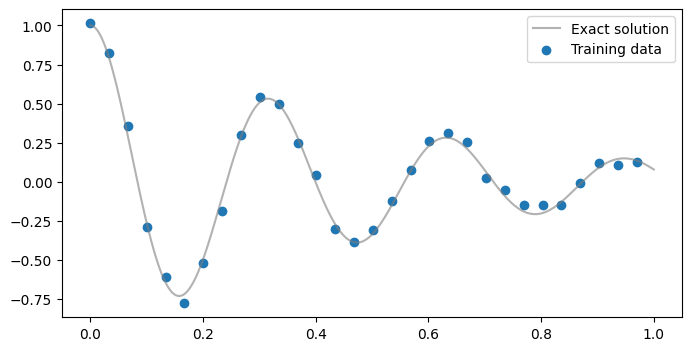

In [3]:
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'][::10].values).view(-1,1)
obs_data = torch.tensor(data['observation'][::10].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true.view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

In [4]:
dev = qml.device("default.qubit.torch", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)


In [5]:
qml.specs(qnode)

<function pennylane.resource.specs.specs.<locals>.specs_qnode(*args, **kwargs)>

In [6]:
# qmodel = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
qmodel = Hybrid_QN(1, 1, qlayer, n_qubits)
# qmodel = Pure_QN(qlayer)

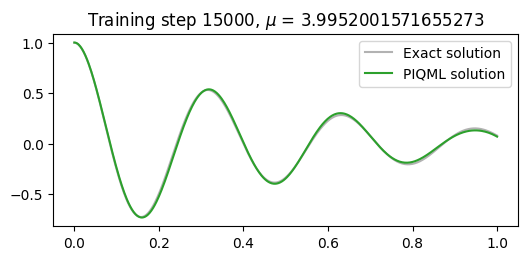

In [7]:
# For initial condition loss
t_initial = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data = t_data.requires_grad_(True)

d = 2
w0 = 20
mu = 2*d
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # mu is missing, let's train it!
all_mus = []

learning_rate=1e-3
optimiser = torch.optim.Adam(list(qmodel.parameters()) + [mu], lr=learning_rate)

lambda1, lambda2 = 1e-1, 1e-5

for i in range(15001):
    optimiser.zero_grad()

    # Loss function for initial conditions
    prediction = qmodel(t_initial)
    loss1, loss2 = boundary_loss(prediction, t_boundary=t_initial)

    # Physics loss with DE
    prediction = qmodel(t_data)
    loss3 = physics_loss(prediction, t_physics=t_data, mu=mu, k=k)

    # Combine loss
    loss:torch.Tensor = loss1 + lambda1*loss2 + lambda2*loss3 + mse(prediction, obs_data)

    # loss:torch.Tensor = lambda2*loss3 + mse(prediction, obs_data)

    loss.backward()

    optimiser.step()

    all_mus.append(mu.item())

    # plot the result as training progresses
    if i % 5000 == 0: 
        prediction = qmodel(t_true).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = qmodel(t_true).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0], label="PIQML solution", color="tab:green")
        plt.title(f"Training step {i}, $\mu$ = {mu.item()}")
        plt.legend()
        plt.show()


In [8]:
## MSE
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - qmodel(t_true)).detach().numpy())**2

1.452872085498365e-06

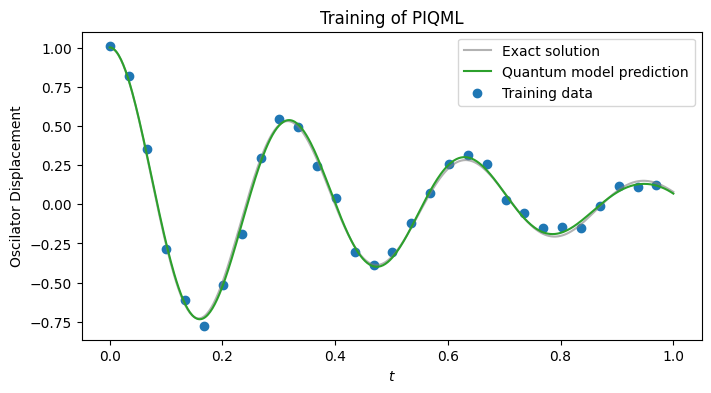

In [9]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    prediction,
    title='Training of PIQML'
    )

mu = Parameter containing:
tensor([3.9952], requires_grad=True)


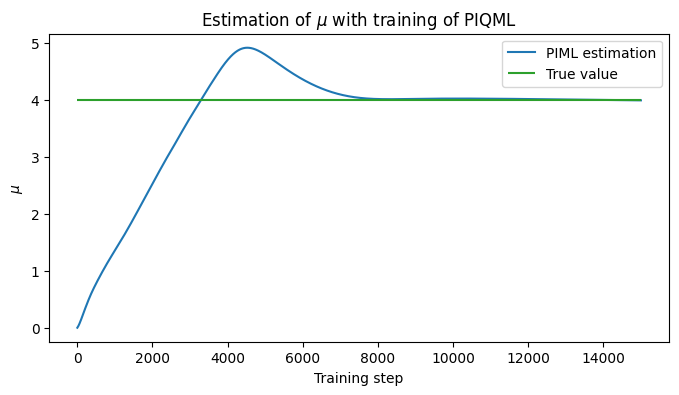

In [10]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIQML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()